In [46]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
os.listdir('data/cell_images')

['test', 'train']

In [5]:
from matplotlib.image import imread

In [40]:
test_path = 'data/cell_images/test/'
train_path = 'data/cell_images/train/'

In [15]:
os.listdir(train_path+'/parasitized')[0]

'C65P26N_ThinF_IMG_20150818_154624_cell_205.png'

In [37]:
para_cell = imread(train_path+'parasitized/C65P26N_ThinF_IMG_20150818_154624_cell_205.png')

para_cell.shape

(145, 142, 3)

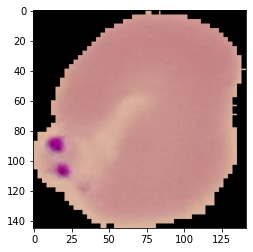

In [38]:
plt.imshow(para_cell)

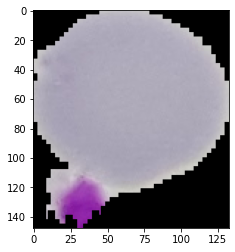

In [26]:
uninfected_cell = imread(train_path+'uninfected/C204ThinF_IMG_20151029_112231_cell_163.png')
plt.imshow(uninfected_cell)

In [41]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'uninfected'):
    img = imread(test_path+'uninfected/'+image_filename)
    d1,d2,d3 = img.shape
    dim1.append(d1)
    dim2.append(d2)

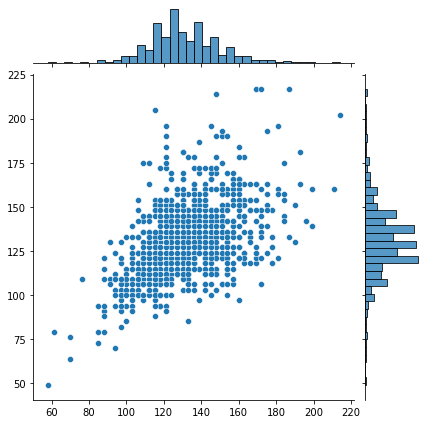

In [43]:
sns.jointplot(dim1,dim2)

In [47]:
np.mean(dim1)

130.92538461538462

In [48]:
np.mean(dim2)

130.75

In [50]:
image_shape = (130,130,3)

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [53]:
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest'
                               #rescale=1/255
                               )

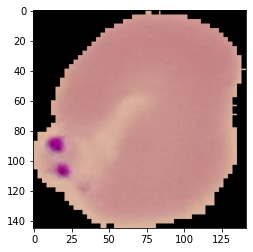

In [61]:
para_image = para_cell
plt.imshow(para_image)

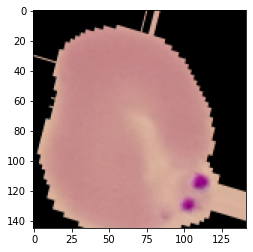

In [66]:
plt.imshow(image_gen.random_transform(para_image))

In [67]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [68]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten

In [81]:
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(3,3),
                 input_shape=image_shape,
                 activation='relu'
                 ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 input_shape=image_shape,
                 activation='relu'
                 ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 input_shape=image_shape,
                 activation='relu'
                 ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )


In [82]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12544)            

In [83]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [84]:
batch_size=16

In [85]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='binary')

Found 24958 images belonging to 2 classes.


In [87]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',
                                               shuffle=False)

Found 2600 images belonging to 2 classes.


In [88]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [89]:
results = model.fit_generator(train_image_gen,
                              epochs=20,
                              validation_data=test_image_gen,
                              callbacks=[early_stop]
                              )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
1560/1560 [==============================] - 229s 147ms/step - loss: 1.1750 - accuracy: 0.5509 - val_loss: 0.6778 - val_accuracy: 0.5885
Epoch 2/20
1560/1560 [==============================] - 228s 146ms/step - loss: 0.6776 - accuracy: 0.5838 - val_loss: 0.6697 - val_accuracy: 0.5904
Epoch 3/20
1560/1560 [==============================] - 234s 150ms/step - loss: 0.6689 - accuracy: 0.5963 - val_loss: 0.6682 - val_accuracy: 0.5938
Epoch 4/20
1560/1560 [==============================] - 225s 144ms/step - loss: 0.6654 - accuracy: 0.6075 - val_loss: 0.4689 - val_accuracy: 0.8146
Epoch 5/20
1560/1560 [==============================] - 221s 141ms/step - loss: 0.2476 - accuracy: 0.9214 - val_loss: 0.2042 - val_accuracy: 0.9300
Epoch 6/20
1560/1560 [==============================] - 219s 140ms/step - loss: 0.1905 - accuracy: 0.9413 - val_loss: 0.1958 - val_accuracy: 0.9338
Epoch 7/20
1560/1560 [==============

In [90]:
pred = model.predict_generator(test_image_gen)

Instructions for updating:
Please use Model.predict, which supports generators.


In [92]:
predictions = pred > 0.5

In [101]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1300
           1       0.92      0.97      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



In [102]:
confusion_matrix(test_image_gen.classes, predictions)

array([[1189,  111],
       [  37, 1263]])

In [106]:
from tensorflow.keras.preprocessing import image
my_image = image.load_img(train_path+'parasitized/C65P26N_ThinF_IMG_20150818_154624_cell_205.png',
                          target_size=image_shape)

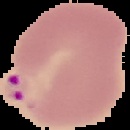

In [107]:
my_image

In [108]:
#model.summary()

In [110]:
my_img_arr = image.img_to_array(my_image)
my_img_arr.shape

(130, 130, 3)

In [113]:
my_img_array = np.expand_dims(my_img_arr, axis=0)
model.predict(my_img_array)

array([[1.7237252e-06]], dtype=float32)

In [114]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}